### Tutorial 5 - Using profiler

This tutorial shows how to use the profiler to measure the performance of your code. We used the same pipeline of the previous tutorial.

The profile is a tool that measures the time spent in each function of your code. It is very useful to identify bottlenecks and to optimize your code. By default it is not enabled and the simplest way to enable the default profiler is to use the `register_default_profiler` function. It will be shown later, in the notebook.

The profile consists in two steps:
1. Register the profiler and execute the desired pipeline. It will generate different files, which contains traces of the execution, in the current directory. Each file will have different information, depending on the plugins attached. Using the `register_default_profiler` function, two plugins will be attached, one to measure the dask task time (and other useful information, such as, per task data shape, type, MB, etc.) and a resource usage plugin (which measure GPU, CPU, memory and IO usage).
2. Perform analysis of the generated files. Some analysis are already implemented in the `profiler` module, but you can also implement your own analysis. For now we have the followig analysis: per function time, per task time and per worker task balance. It will be shown later, in the notebook.

## Enabling profiling

In [1]:
import numpy as np

from dasf.datasets import make_blobs

n_samples = 100000
n_bins = 3

# Generate 3 blobs with 2 classes where the second blob contains
# half positive samples and half negative samples. Probability in this
# blob is therefore 0.5.
centers = [(-6, -6), (0, 0), (9, 1)]
X, y = make_blobs(n_samples=n_samples, centers=centers, shuffle=False, random_state=42)

np.save("X.npy", X)
np.save("y.npy", y)

In [2]:
from dasf.datasets import DatasetArray
from dasf.datasets import DatasetLabeled


class MyMakeBlobs(DatasetLabeled):
    def __init__(self):
        super().__init__(name="My Own make_blobs()", download=False)
        
        # Let's assign the train and val data.
        self._train = DatasetArray(name="X", download=False, root="X.npy", chunks=(5000, 2))
        self._val = DatasetArray(name="y", download=False, root="y.npy", chunks=(5000))

make_blobs = MyMakeBlobs()

In [3]:
from dasf.transforms import Normalize

normalize = Normalize()

In [4]:
from dasf.pipeline.executors import DaskPipelineExecutor

dask = DaskPipelineExecutor(local=True, use_gpu=True)

2023-08-15 11:55:48,568 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-15 11:55:48,568 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-15 11:55:48,568 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-15 11:55:48,568 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-15 11:55:48,673 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-15 11:55:48,673 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
2023-08-15 11:55:48,752 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2023-08-15 11:55:48,752 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize


In [5]:
from dasf.ml.cluster import KMeans
from dasf.ml.cluster import SOM

kmeans = KMeans(n_clusters=3, max_iter=100)
som = SOM(x=1, y=3, input_len=2, num_epochs=100)

In [6]:
from dasf.transforms import PersistDaskData

persist_kmeans = PersistDaskData()
persist_som = PersistDaskData()

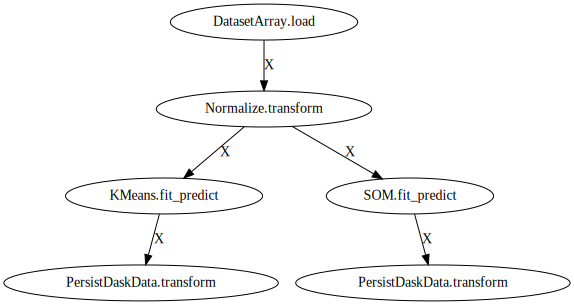

In [7]:
from dasf.pipeline import Pipeline

pipeline = Pipeline("A KMeans and SOM Pipeline", executor=dask)

pipeline.add(normalize, X=make_blobs._train) \
        .add(kmeans.fit_predict, X=normalize) \
        .add(som.fit_predict, X=normalize) \
        .add(persist_kmeans, X=kmeans.fit_predict) \
        .add(persist_som, X=som.fit_predict) \
        .visualize()

Once you created your pipeline we can attach the profiler to it. The profiler will collect the data and store it in a file (one for each plugin). The file will be stored in the same directory as the notebook. The file name will be controled by the `name` parameter followed by `.msgpack` extension. If you do not provide the `name` parameter it will be `default`.

The `enable_nvtx` parameter will enable the NVTX markers. This will allow you to see the pipeline in the NVIDIA Nsight Systems. This is only available on NVIDIA GPUs.

Finally, the `add_time_suffix` parameter will add the current time to the file name (useful for unique file names).In this way you can run the same pipeline multiple times and get different files. The file name will be `name_time.msgpack`.

In [8]:
from dasf.profile import register_default_profiler

register_default_profiler(
    pipeline,
    name="Tutorial_5_Profile",
    enable_nvtx=False,
    add_time_suffix=False   
)

Registered worker plugin: Tutorial_5_Profile-TracePlugin
Registered resource plugin: Tutorial_5_Profile-ResourceMonitor


In [9]:
%time pipeline.run()

[2023-08-15 11:55:50-0300] INFO - Beginning pipeline run for 'A KMeans and SOM Pipeline'
[2023-08-15 11:55:50-0300] INFO - Task 'DatasetArray.load': Starting task run...
[2023-08-15 11:55:50-0300] INFO - Task 'DatasetArray.load': Finished task run
[2023-08-15 11:55:50-0300] INFO - Task 'Normalize.transform': Starting task run...
[2023-08-15 11:55:50-0300] INFO - Task 'Normalize.transform': Finished task run
[2023-08-15 11:55:50-0300] INFO - Task 'KMeans.fit_predict': Starting task run...
[2023-08-15 11:55:55-0300] INFO - Task 'KMeans.fit_predict': Finished task run
[2023-08-15 11:55:55-0300] INFO - Task 'SOM.fit_predict': Starting task run...
[2023-08-15 11:56:21-0300] INFO - Task 'SOM.fit_predict': Finished task run
[2023-08-15 11:56:21-0300] INFO - Task 'PersistDaskData.transform': Starting task run...
[2023-08-15 11:56:21-0300] INFO - Task 'PersistDaskData.transform': Finished task run
[2023-08-15 11:56:21-0300] INFO - Task 'PersistDaskData.transform': Starting task run...
[2023-08-

The resource monitor plugin runs indefinitely, until the program exits. As the database are buffered, in order to reduce the IO pressure, the data are flushed to the database only after 5000 entries (or when program exits). We can shutdown the executor, in order to flush the data to the database.

In [10]:
dask.shutdown()

2023-08-15 11:56:54,586 - distributed.active_memory_manager - WARNING - Tried retiring worker tcp://127.0.0.1:35871, but 14 tasks could not be moved as there are no suitable workers to receive them. The worker will not be retired.
2023-08-15 11:56:54,587 - distributed.active_memory_manager - WARNING - Tried retiring worker tcp://127.0.0.1:35148, but 14 tasks could not be moved as there are no suitable workers to receive them. The worker will not be retired.
2023-08-15 11:56:54,587 - distributed.active_memory_manager - WARNING - Tried retiring worker tcp://127.0.0.1:38191, but 16 tasks could not be moved as there are no suitable workers to receive them. The worker will not be retired.
2023-08-15 11:56:54,588 - distributed.active_memory_manager - WARNING - Tried retiring worker tcp://127.0.0.1:39400, but 14 tasks could not be moved as there are no suitable workers to receive them. The worker will not be retired.


## Analysing the profile data

Once the code ran, and traceevents were collected, we can perform analysis to understand the performance of the code. The first step is the load the databases. The `register_default_profiler` attachs two plugins `TracePlugin` (which trace dask tasks) and `ResourceMonitorPlugin` (which traces the resource usage of the workers). So there will be two files: `Tutorial_5_Profile-ResourceMonitor-c096.msgpack` and `Tutorial_5_Profile-TracePlugin-c096.msgpack`. We can load the events using the `EventProfiler` class (the same used to register events).

In [2]:
from dasf.profile.profiler import EventProfiler
from dasf.profile import MultiEventDatabase

db1 = EventProfiler("Tutorial_5_Profile-ResourceMonitor-c096.msgpack")
db2 = EventProfiler("Tutorial_5_Profile-TracePlugin-c096.msgpack")

db1, db2

(EventProfiler(database=FileDatabase at Tutorial_5_Profile-ResourceMonitor-c096.msgpack),
 EventProfiler(database=FileDatabase at Tutorial_5_Profile-TracePlugin-c096.msgpack))

Database are collection of events. Each event is a dataclass and follows the [Chrome Trace Event Format](https://docs.google.com/document/d/1CvAClvFfyA5R-PhYUmn5OOQtYMH4h6I0nSsKchNAySU/preview). The `EventProfiler` class is a wrapper around a list of events. It provides methods to add events and to write the database to a file.

We can iterate over the events in a database using the `get_traces` function. It will return an iterator over the events in the database. The events are returned in the order they were recorded. 

In [4]:
for event in db1.get_traces():
    print(event)
    break

for event in db2.get_traces():
    print(event)
    break

InstantEvent(name='Resource Usage', timestamp=3869.01274743, phase='I', scope='g', process_id='c096', thread_id=None, args={'cpu': 40.2, 'memory': 2744729600, 'time': 1692111381.5415905, 'host_net_io.read_bps': 10685583.118998485, 'host_net_io.write_bps': 10673829.571746167, 'host_disk_io.read_bps': 0.0, 'host_disk_io.write_bps': 134589.30723739465, 'num_fds': 189, 'gpu_utilization': 0, 'gpu_memory_used': 3158966272})
CompleteEvent(name='Compute', timestamp=3837.884328029, duration=0.050518035888671875, phase='X', process_id='c096', thread_id='worker-c096-2', args={'key': 'getGPUs-42237764-1836-4be8-ae62-948ce02e1d6a', 'name': 'tGPUs-42237764-1836-4be8-ae62', 'state': 'memory', 'size': 280, 'shape': [], 'dtype': 'unknown', 'type': "<class 'list'>", 'dependencies': [], 'dependents': []})


The `MultiEventDatabase` allow use traverse multiple databases at the same time (usually, needed for analyses).

In [5]:
database = MultiEventDatabase([db1, db2])
database

MultiEventDatabase with 2 databases

In [6]:
for event in database:
    print(event)
    break

InstantEvent(name='Resource Usage', timestamp=3869.01274743, phase='I', scope='g', process_id='c096', thread_id=None, args={'cpu': 40.2, 'memory': 2744729600, 'time': 1692111381.5415905, 'host_net_io.read_bps': 10685583.118998485, 'host_net_io.write_bps': 10673829.571746167, 'host_disk_io.read_bps': 0.0, 'host_disk_io.write_bps': 134589.30723739465, 'num_fds': 189, 'gpu_utilization': 0, 'gpu_memory_used': 3158966272})


Or generate a list with all events

In [7]:
all_events = list(database)
all_events[:10]

[InstantEvent(name='Resource Usage', timestamp=3869.01274743, phase='I', scope='g', process_id='c096', thread_id=None, args={'cpu': 40.2, 'memory': 2744729600, 'time': 1692111381.5415905, 'host_net_io.read_bps': 10685583.118998485, 'host_net_io.write_bps': 10673829.571746167, 'host_disk_io.read_bps': 0.0, 'host_disk_io.write_bps': 134589.30723739465, 'num_fds': 189, 'gpu_utilization': 0, 'gpu_memory_used': 3158966272}),
 InstantEvent(name='Resource Usage', timestamp=3869.018545822, phase='I', scope='g', process_id='c096', thread_id=None, args={'cpu': 0.0, 'memory': 2744729600, 'time': 1692111381.5495014, 'host_net_io.read_bps': 24242915.31342638, 'host_net_io.write_bps': 24415081.283950076, 'host_disk_io.read_bps': 0.0, 'host_disk_io.write_bps': 0.0, 'num_fds': 189, 'gpu_utilization': 0, 'gpu_memory_used': 3158966272}),
 InstantEvent(name='Resource Usage', timestamp=3869.118886256, phase='I', scope='g', process_id='c096', thread_id=None, args={'cpu': 69.9, 'memory': 2744729600, 'time':

In [8]:
all_events[-10:]

[InstantEvent(name='Managed Memory', timestamp=3907.782270047, phase='I', scope='g', process_id='c096', thread_id='worker-c096-1', args={'key': "('reshape-b1532816c7b1745efbdc8cb9a24f29f9', 0, 0)", 'state': 'memory', 'size': 300048, 'tasks': 17}),
 CompleteEvent(name='Compute', timestamp=3907.792064168, duration=8.106231689453125e-06, phase='X', process_id='c096', thread_id='worker-c096-1', args={'key': 'original-array-64bef1cc631f078a2e8f3d2c24d62e99', 'name': 'iginal-array', 'state': 'memory', 'size': 8, 'shape': [2], 'dtype': 'float32', 'type': "<class 'cupy._core.core.ndarray'>", 'dependencies': [], 'dependents': []}),
 InstantEvent(name='Managed Memory', timestamp=3907.792064168, phase='I', scope='g', process_id='c096', thread_id='worker-c096-1', args={'key': 'original-array-64bef1cc631f078a2e8f3d2c24d62e99', 'state': 'memory', 'size': 300032, 'tasks': 15}),
 CompleteEvent(name='Compute', timestamp=3907.792960693, duration=5.4836273193359375e-06, phase='X', process_id='c096', thre

Given a `MultiEventDatabase` we can use the `TraceAnalyser` that perform analyses over the database. It is useful to find bottlenecks in the code and to understand how the code is executed. 

In [9]:
from dasf.profile import TraceAnalyser
analyser = TraceAnalyser(database)

### Function Bottleneck Report

The function bootleneck report will show us the function that is taking the most time to run. This is useful for optimizing code. Here, a function is composed by a set of tasks that applies this function in different chunks of data. It is the function used by `map_blocks` (where a function is applyed to several chunks). This report is a dataframe with the following columns:
- `Host`: the host where the function is running
- `GPU`: the GPU where the function is running
- `Function`: the function name
- `Duration`: the time spent in the function
- `Percentage of total time (%)`: the percentage of total compute time spent in the function
- `Mean GPU Utilization (%)`: the mean GPU utilization during the function execution
- `Mean GPU Memory Used (GB)`: the mean GPU memory used during the function execution
- `Mean Data Size (MB)`: the mean data size used during the function execution (as input)
- `Mean Data Throughput (MB/s)`: the mean data throughput during the function execution (as input)
- `Num tasks (chunks)`: the number of tasks (chunks) that the function was applied
- `Mean Task Time (s)`: the mean time spent in each task (chunk)

In [5]:
func_bottleneck_dataframe = analyser.per_function_bottleneck()
func_bottleneck_dataframe.head(10)

[function_bottleneck] Creating dataframe: 100%|██████████████████████████████████████| 4/4 [00:00<00:00, 41.34it/s]


,Host,GPU,Function,Duration (s),Percentage of total time (%),Mean GPU Utilization (%),Mean GPU Memory Used (GB),Mean Data Size (MB),Mean Throughput (MB/s),Num Tasks (chunks),Mean Task time (s)
624,c096,0,unc_fit-62a75b12-6b7a-49b0-b279,2.471439,34.967563,0.0,0.000000,0.160000,0.064740,1,2.471439
1753,c096,1,unc_fit-2d612856-11c9-4d72-8062,2.471328,35.497386,0.0,0.000000,0.200000,0.080928,1,2.471328
10,c096,2,unc_fit-abdc6ba0-f141-4e3c-909e,2.463677,33.690773,0.0,0.000000,0.240000,0.097415,1,2.463677
1228,c096,3,unc_fit-d813c7ea-7042-4c69-8a72,2.463437,34.930821,0.0,0.000000,0.200000,0.081187,1,2.463437
8,c096,2,var-partial,1.172959,16.040208,0.0,0.000000,0.000908,0.619854,685,0.001712
1750,c096,1,var-partial,1.105952,15.885550,0.0,0.000000,0.000907,0.624356,670,0.001651
1225,c096,3,var-partial,1.049221,14.877642,0.0,0.000000,0.000907,0.617285,639,0.001642
622,c096,0,var-partial,1.018737,14.413764,0.0,0.000000,0.000906,0.623162,570,0.001787
1223,c096,3,var,0.825022,11.698578,0.0,0.000000,0.040000,70.562086,711,0.001160
621,c096,0,mean_combine-partial,0.534140,7.557362,1.0,3.158966,0.000752,1.198554,674,0.000792


### Task Bootleneck Report

The task bottleneck report shows the tasks that are the most time consuming in the application. This is similar to the above report, but is per task instead of per function (i.e., each block). This is similar to DASK task breakdown report.

In [6]:
task_bottleneck_dataframe = analyser.per_task_bottleneck()
task_bottleneck_dataframe.head(10)

[task_bottleneck] Creating dataframe: 100%|██████████████████████████████████████████| 4/4 [00:00<00:00,  5.47it/s]


,Host,GPU,Task Key,Duration (s),Percentage of total time (%),Memory usage (Mb)
10453,c096,0,_func_fit-62a75b12-6b7a-49b0-b279-160a8ff3ee3b,2.471439,34.967563,0.000048
31484,c096,1,_func_fit-2d612856-11c9-4d72-8062-7dfff911cf37,2.471328,35.497386,0.000048
59,c096,2,_func_fit-abdc6ba0-f141-4e3c-909e-059f1f2eed4f,2.463677,33.690773,0.000048
21017,c096,3,_func_fit-d813c7ea-7042-4c69-8a72-7bdafcec69fb,2.463437,34.930821,0.000048
31507,c096,1,_update-96127d18-5249-4874-accc-a95d91831a7f,0.452484,6.499339,0.000092
10497,c096,0,_update-988648be-51da-405b-a484-a25c9db01ee3,0.430781,6.094980,0.000092
83,c096,2,_update-8c69b565-dc4d-4abc-80bb-e8085e2960bb,0.426465,5.831903,0.000092
21070,c096,3,_update-af7e6144-6bc1-4f85-9b66-4dd7e5f241d0,0.425992,6.040446,0.000092
21006,c096,3,"('var-e4678ef53eb782384180081aa58da0be', 13, 0)",0.363825,5.158930,0.000450
9,c096,2,('mean_chunk-0ff2c4ec843f304adcd7d25ca35c47a7'...,0.259243,3.545143,0.000376


### Task balance

This report show the number of tasks in memory (per worker), in each instant of time. This is useful to check imbalance in the load of the workers.

In [7]:
task_balance_dataframe = analyser.per_worker_task_balance()
task_balance_dataframe.head(10)

[task_balance] Creating dataframe: 100%|███████████████████████████████████████| 71/71 [00:00<00:00, 359222.66it/s]


,Time Interval (seconds from begin),worker-c096-0,worker-c096-1,worker-c096-2,worker-c096-3
0,0,0.0,0.0,1.0,1.0
1,1,10.0,12.0,16.0,11.0
2,6,33.0,13.0,15.0,35.0
3,7,8.0,14.0,32.0,17.0
4,8,32.0,15.0,31.0,20.0
5,9,32.0,30.0,19.0,19.0
6,10,14.0,14.0,14.0,15.0
7,11,13.0,15.0,14.0,21.0
8,12,16.0,19.0,9.0,16.0
9,13,18.0,15.0,17.0,20.0
